In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.ticker as mtick
from sklearn.metrics import mean_squared_error

In [2]:
rates=pd.read_excel('hypothetical_data_set.xlsx', sheet_name='Hypothetical rates', header=1)
portfolio=pd.read_excel('hypothetical_data_set.xlsx', sheet_name='Hypothetical portfolio', header=1)

In [3]:
ftp=rates.iloc[:,:6]
euribor=rates.iloc[:,7:]

In [4]:
new_column_names = {'3Y.1': '3Y', '5Y.1': '5Y', '10Y.1': '10Y'}

# Rename columns
euribor.rename(columns=new_column_names, inplace=True)

In [5]:
# Sample data setup
train_data = euribor.iloc[:96, 1:]
test_data = euribor.iloc[96:, 1:]

In [40]:
def create_ns_matrix(tau, lamb):
    tau = np.atleast_1d(tau)
    lamb = np.atleast_1d(lamb)
    ns_matrix = np.zeros((len(tau), 3))

    for i in range(len(tau)):
        ns_matrix[i, 0] = 1
        ns_matrix[i, 1] = (1 - np.exp(-lamb * tau[i])) / (lamb * tau[i])
        ns_matrix[i, 2] = ns_matrix[i, 1] - np.exp(-lamb * tau[i])

    ns_df = pd.DataFrame(ns_matrix, columns=['1', '(1-e^-λτ)/λτ', '(1-e^-λτ)/λτ - e^-λτ'])
    return ns_df

def estimate_betas(Y, tau_example, lambda_example):
    B = create_ns_matrix(tau_example, lambda_example)
    BBi = np.linalg.inv(B.T @ B)
    betas = np.linalg.inv(B.T @ B) @ B.T @ Y.T

    beta1 = betas.iloc[0, :]
    beta2 = betas.iloc[1, :]
    beta3 = betas.iloc[2, :]

    cs = []
    phis = []
    eta = []
    for beta in [beta1, beta2, beta3]:
        beta_lagged = beta[:-1].values
        beta_current = beta[1:].values
        beta_lagged_with_constant = sm.add_constant(beta_lagged)
        model = sm.OLS(beta_current, beta_lagged_with_constant)
        results = model.fit()

        c_estimate = results.params[0]
        phi_estimate = results.params[1]
        eta_estimate = results.resid

        cs.append(c_estimate)
        phis.append(phi_estimate)
        eta.append(eta_estimate)

    beta1s = list(beta1.values)
    beta1_np = np.zeros(120)

    for i in range(120):
        beta1s.append(cs[0] + phis[0] * beta1s[-1])
        beta1_np[i] = cs[0] + phis[0] * beta1s[-1]

    beta2s = list(beta2.values)
    beta2_np = np.zeros(120)

    for i in range(120):
        beta2s.append(cs[1] + phis[1] * beta2s[-1])
        beta2_np[i] = cs[1] + phis[1] * beta2s[-1]

    beta3s = list(beta3.values)
    beta3_np = np.zeros(120)

    for i in range(120):
        beta1s.append(cs[2] + phis[2] * beta3s[-1])
        beta3_np[i] = cs[2] + phis[2] * beta3s[-1]

    betas = np.row_stack((beta1_np, beta2_np, beta3_np))
    return B, betas, eta

# Sample data setup
train_data = euribor.iloc[:, 1:]
#test_data = euribor.iloc[96:, 1:]

# Define maturities
maturities = ["6M", "1Y", "3Y", "5Y", "10Y"]
Y = train_data.values

lambda_example = 0.1      # Replace with desired λ value
tau_example = np.array([6, 12, 36, 60, 120])
Y = train_data.values
B, betas, eta = estimate_betas(Y, tau_example, lambda_example)
y = B@betas

y=y.T
new_column_names = {0: '6M', 1: '1Y', 2: '3Y', 3:'5Y', 4:'10Y'}

# Rename columns
y.rename(columns=new_column_names, inplace=True)
#print(y)
#y.to_excel("DNS_forecasts.xlsx", index=True)



In [27]:
import numpy as np

# Define the model equation using the estimated parameters (B matrix and beta coefficients)
def simulate_euribor_rates(B, beta, initial_values, num_years, num_months):
    # Initialize an array to store the simulated Euribor rates
    euribor_rates = np.zeros((num_years * 12, len(initial_values)))
    
    # Set the initial values
    euribor_rates[0] = initial_values
    
    # Simulate future values
    for i in range(1, num_years * 12):
        # Calculate the next value using the model equation
        euribor_rates[i] = np.dot(B, euribor_rates[i-1]) + np.dot(beta, np.random.normal(size=len(beta)))
    
    return euribor_rates

initial_values = euribor.iloc[-1,1:]  # Your initial values
num_years = 10
num_months = 12

# Simulate Euribor rates
simulated_euribor_rates = simulate_euribor_rates(B.iloc[:,0], betas[0,:], initial_values, num_years, num_months)

# Print the simulated Euribor rates
print(len(simulated_euribor_rates))


120


In [44]:
print(y)

           6M        1Y        3Y        5Y       10Y
0   -0.004785 -0.004578 -0.001622  0.000302  0.002082
1   -0.004550 -0.004386 -0.001511  0.000386  0.002145
2   -0.004337 -0.004213 -0.001409  0.000464  0.002204
3   -0.004145 -0.004056 -0.001316  0.000536  0.002259
4   -0.003972 -0.003913 -0.001230  0.000603  0.002312
..        ...       ...       ...       ...       ...
115 -0.001896 -0.002080  0.000154  0.001838  0.003427
116 -0.001895 -0.002080  0.000155  0.001839  0.003428
117 -0.001894 -0.002079  0.000156  0.001839  0.003429
118 -0.001894 -0.002078  0.000156  0.001840  0.003429
119 -0.001893 -0.002078  0.000157  0.001841  0.003430

[120 rows x 5 columns]


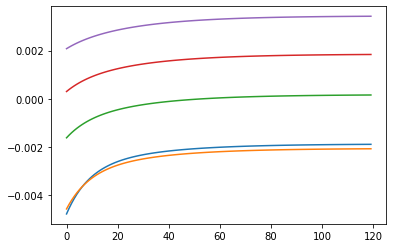

In [45]:
plt.plot(y)

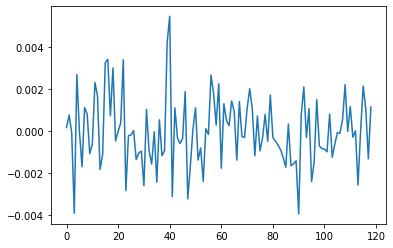

In [57]:
plt.plot(pd.DataFrame(eta).iloc[0,:].T)

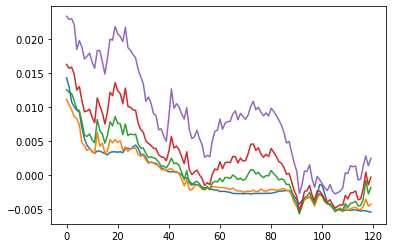

In [11]:
plt.plot(euribor.iloc[:,1:])

In [18]:
from scipy.stats import kstest, norm, gamma
for i in y.columns:
    fit_params = norm.fit(euribor[i])
    # Perform the KS test for a normal distribution
    statistic, p_value = kstest(euribor[i], 'norm', fit_params)

    # Print the results
    print("KS Statistic:", statistic)
    print("P-value:", p_value)
    print(fit_params)

KS Statistic: 0.176070173669637
P-value: 0.0010042294948440712
(-0.000423, 0.004067142649739905)
KS Statistic: 0.21574638508948119
P-value: 2.2074621553382096e-05
(-0.00043112500000000014, 0.003835431063480132)
KS Statistic: 0.13463537787440982
P-value: 0.023353737958115874
(0.0008646999999999999, 0.004363362525239757)
KS Statistic: 0.11657551312283365
P-value: 0.07063241661744492
(0.00310595, 0.005406965032637687)
KS Statistic: 0.10359672716332569
P-value: 0.14177089657813002
(0.00853125, 0.00721865769637957)
